In [1]:
DATA_DIR = "benchmark-many-gpus-scratch"

In [2]:
%matplotlib inline

In [3]:
XFER_TYPE_MAPPING = {
        0: "Storage->GPU (GDS)",
        1: "Storage->CPU",
        2: "Storage->CPU->GPU",
#         3: "Storage->CPU->GPU_ASYNC",
#         4: "Storage->PAGE_CACHE->CPU->GPU",
#         5: "Storage->GPU_ASYNC",
#         6: "Storage->GPU_BATCH" # Experiments failed
    }

In [4]:
OPERATION_TYPE_MAPPING = {
        0: "read",
        1: "write",
        2: "randread",
        3: "randwrite"
    }

In [5]:
xfer_types_to_skip = set(range(7)).difference(XFER_TYPE_MAPPING)
print(xfer_types_to_skip)

{3, 4, 5, 6}


# Throughput and latency

In [6]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns

In [7]:
def parse_xfer_type(type_):
    return XFER_TYPE_MAPPING[int(type_)]

In [8]:
def parse_operation_type(type_):
    return OPERATION_TYPE_MAPPING[int(type_)]

In [9]:
params_path_pattern = r"benchmark-(\d+)-([^-]+)-\d+-([01])-" # "benchmark-$X-$RW-$W-${ENABLE_NVLINKS}-${SLURM_JOB_ID}"
results_pattern = r"Throughput: ([^\s]+) GiB/sec, Avg_Latency: ([^\s]+) usecs"

measurements = []


def read_from_path(suffix, num_gpus):
    data_dir = DATA_DIR + suffix
    pathlist = Path(data_dir).glob('slurm-benchmark-*.out')

    for path in pathlist:
        with open(path, "r") as f:
            content = f.read()
        slurm_job_id = re.search(r"slurm-benchmark-(\d+).out", str(path)).group(1)

        results_dir = next(Path(data_dir).glob(f"benchmark-*-{slurm_job_id}"))

        params_match = re.search(params_path_pattern, str(results_dir))
        results_match = re.search(results_pattern, content)
        if int(params_match.group(1)) in xfer_types_to_skip:
            continue
        measurements.append({
            "xfer_type": parse_xfer_type(params_match.group(1)),
            "op_type": params_match.group(2),
            "nvlink": params_match.group(3) == "1",
            "num_gpus": num_gpus,
            "throughput (GiB/sec)": float(results_match.group(1)),
            "latency (usecs)": float(results_match.group(2))
        })

read_from_path("", 8)
read_from_path("-one-gpu", 1)
measurements_df = pd.DataFrame(measurements)

In [10]:
measurements_df["xfer_type"] = measurements_df["xfer_type"].astype(
    CategoricalDtype(categories=XFER_TYPE_MAPPING.values(), ordered=True)
)
measurements_df["op_type"] = measurements_df["op_type"].astype(
    CategoricalDtype(categories=OPERATION_TYPE_MAPPING.values(), ordered=True)
)

In [11]:
measurements_df

,xfer_type,op_type,nvlink,num_gpus,throughput (GiB/sec),latency (usecs)
0,Storage->CPU,randread,True,8,6.514975,38331.854901
1,Storage->GPU (GDS),randread,True,8,6.386999,38885.963145
2,Storage->GPU (GDS),write,False,8,6.773941,36861.733616
3,Storage->CPU->GPU,randwrite,False,8,4.400127,56747.968982
4,Storage->GPU (GDS),randwrite,False,8,5.246297,47649.270066
...,...,...,...,...,...,...
91,Storage->GPU (GDS),randread,True,1,6.688004,4670.207492
92,Storage->GPU (GDS),randread,True,1,5.880313,2657.114838
93,Storage->CPU,read,False,1,7.343803,2126.461560
94,Storage->CPU->GPU,randwrite,True,1,4.591945,3402.072901


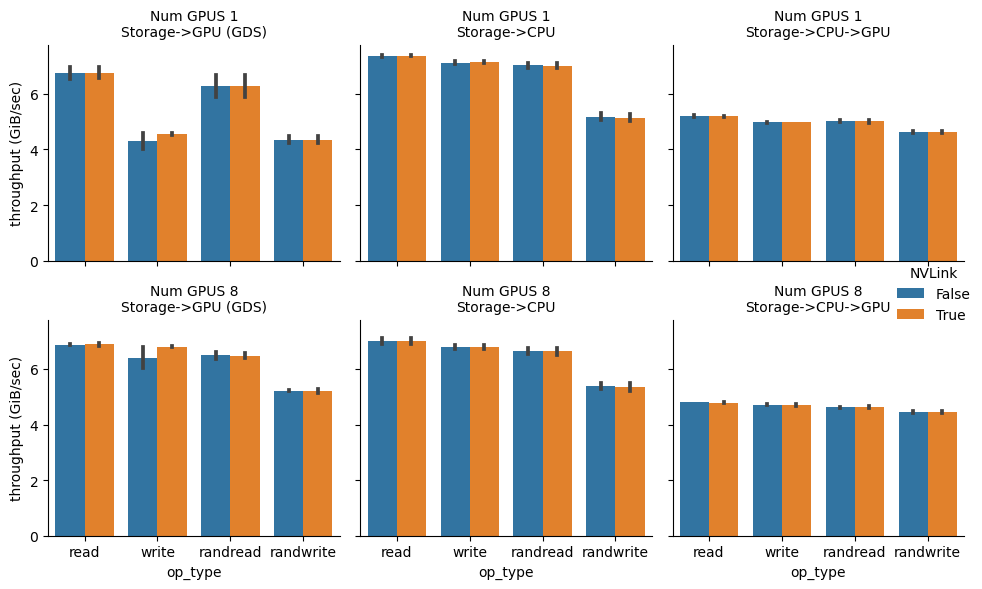

In [12]:
g = sns.FacetGrid(measurements_df, col="xfer_type", row="num_gpus")
g.set_titles("Num GPUS {row_name}\n{col_name}")
g.map_dataframe(
    sns.barplot, x="op_type", y="throughput (GiB/sec)", hue="nvlink",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVLink")
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/throughput-dgx-4-raid.jpg", dpi='figure')
plt.show()

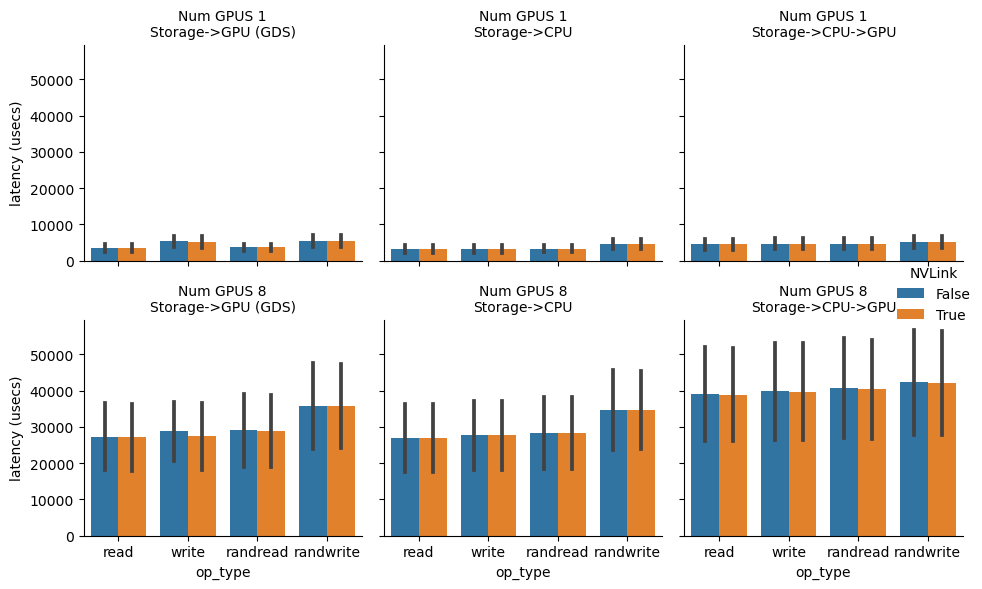

In [13]:
g = sns.FacetGrid(measurements_df, col="xfer_type", row="num_gpus")
g.set_titles("Num GPUS {row_name}\n{col_name}")
g.map_dataframe(
    sns.barplot, x="op_type", y="latency (usecs)", hue="nvlink",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVLink")
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/latency-dgx-4-raid.jpg", dpi='figure')
plt.show()

# CPU burden

In [14]:
single_metrics_pattern = r"\s*([^\s]+)"
cpu_usage_pattern = rf"avg-cpu:  %user   %nice %system %iowait  %steal   %idle\n{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}"

In [15]:
cpu_measurements = []

def read_cpu_from_path(suffix, num_gpus):
    data_dir = DATA_DIR + suffix
    pathlist = Path(data_dir).glob('benchmark-*')

    for path in pathlist:
        with open(path / "iostat.out", "r") as f:
            content = f.read()

        cpu_matches = re.findall(cpu_usage_pattern, content)
        params_match = re.search(params_path_pattern, str(path))

        if int(params_match.group(1)) in xfer_types_to_skip:
            continue

        for i, cpu_match in enumerate(cpu_matches[1:-1], start=1):
            cpu_measurements.append({
                "xfer_type": parse_xfer_type(params_match.group(1)),
                "op_type": params_match.group(2),
                "nvlink": params_match.group(3) == "1",
                "observation_index": i,
                "num_gpus": num_gpus,
                **dict(zip(["user_cpu", "nice_cpu", "system_cpu", "iowait_cpu", "steal_cpu", "idle_cpu"], cpu_match))
            })

read_cpu_from_path("", 8)
read_cpu_from_path("-one-gpu", 1)
cpu_measurements_df = pd.DataFrame(cpu_measurements)

In [16]:
cpu_measurements_df["xfer_type"] = cpu_measurements_df["xfer_type"].astype(
    CategoricalDtype(categories=XFER_TYPE_MAPPING.values(), ordered=True)
)
cpu_measurements_df["op_type"] = cpu_measurements_df["op_type"].astype(
    CategoricalDtype(categories=OPERATION_TYPE_MAPPING.values(), ordered=True)
)
for col in cpu_measurements_df.columns:
    if col.endswith("cpu"):
        cpu_measurements_df[col] = cpu_measurements_df[col].astype(float)

In [17]:
cpu_measurements_df

,xfer_type,op_type,nvlink,observation_index,num_gpus,user_cpu,nice_cpu,system_cpu,iowait_cpu,steal_cpu,idle_cpu
0,Storage->CPU->GPU,read,True,1,8,0.18,0.0,1.23,0.0,0.0,98.59
1,Storage->CPU->GPU,read,True,2,8,0.25,0.0,1.72,0.0,0.0,98.03
2,Storage->CPU->GPU,read,True,3,8,0.37,0.0,1.59,0.0,0.0,98.04
3,Storage->CPU->GPU,read,True,4,8,0.31,0.0,1.73,0.0,0.0,97.95
4,Storage->CPU->GPU,read,True,5,8,0.27,0.0,1.57,0.0,0.0,98.16
...,...,...,...,...,...,...,...,...,...,...,...
622,Storage->CPU->GPU,randwrite,True,1,1,0.24,0.0,1.81,0.0,0.0,97.95
623,Storage->CPU->GPU,randwrite,True,2,1,0.24,0.0,1.73,0.0,0.0,98.03
624,Storage->CPU->GPU,randwrite,True,3,1,0.25,0.0,1.77,0.0,0.0,97.98
625,Storage->CPU->GPU,randwrite,True,4,1,0.29,0.0,1.73,0.0,0.0,97.98


In [18]:
cpu_measurements_df.groupby(["xfer_type", "op_type", "nvlink", "num_gpus"]).count().min()

observation_index    8
user_cpu             8
nice_cpu             8
system_cpu           8
iowait_cpu           8
steal_cpu            8
idle_cpu             8
dtype: int64

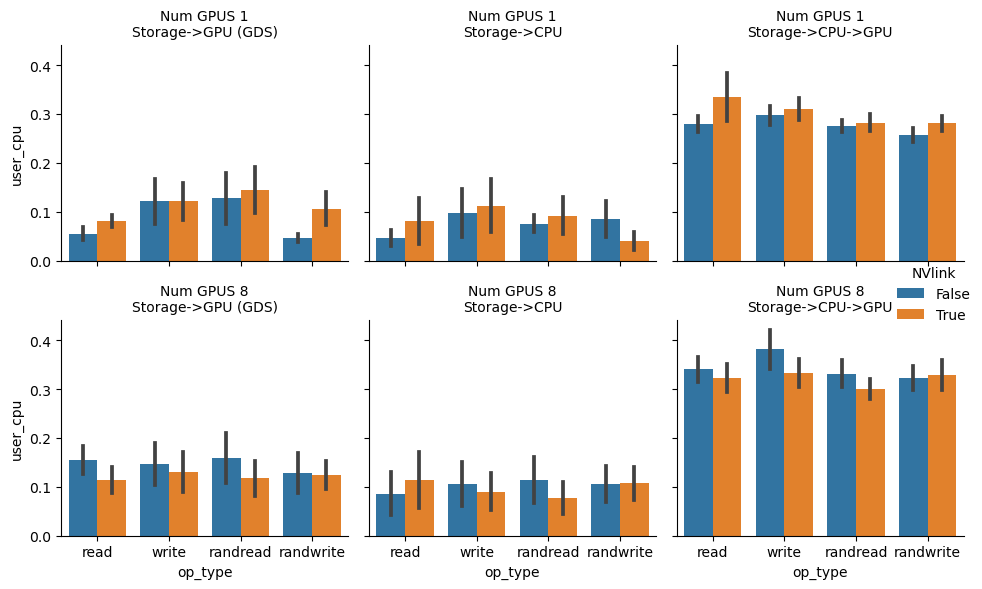

In [19]:
g = sns.FacetGrid(cpu_measurements_df, col="xfer_type", row="num_gpus")
g.set_titles("Num GPUS {row_name}\n{col_name}")
g.map_dataframe(
    sns.barplot, x="op_type", y="user_cpu", hue="nvlink", errorbar="se",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVlink")
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/cpu-user-dgx-4-raid.jpg", dpi='figure')
plt.show()

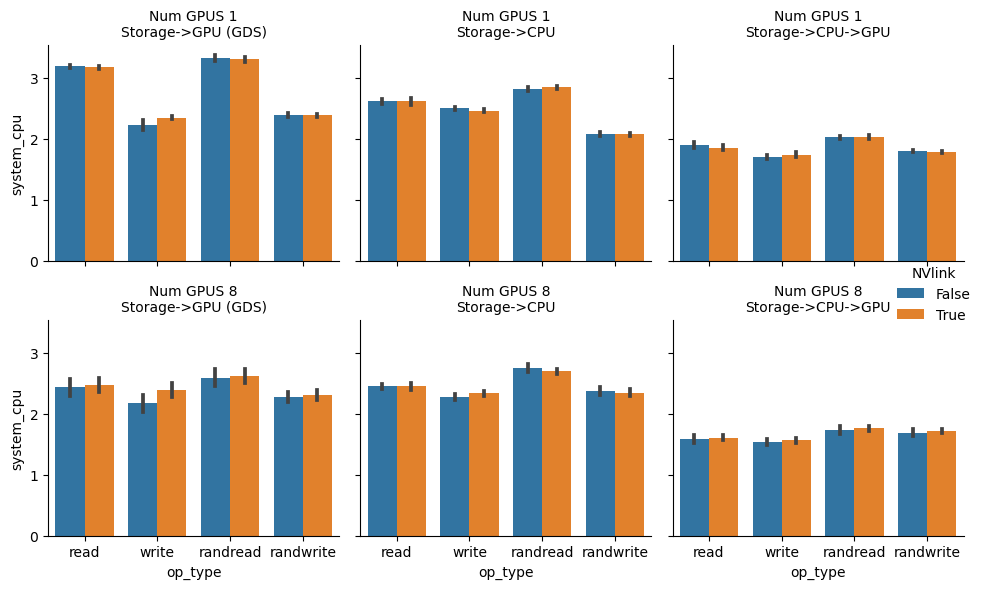

In [20]:
g = sns.FacetGrid(cpu_measurements_df, col="xfer_type", row="num_gpus")
g.set_titles("Num GPUS {row_name}\n{col_name}")
g.map_dataframe(
    sns.barplot, x="op_type", y="system_cpu", hue="nvlink", errorbar="se",
    palette=sns.color_palette(n_colors=2)
)
g.add_legend(title="NVlink")
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/cpu-system-dgx-4-raid", dpi=500)
plt.show()